# Complete Example of Embedding a clean PDF into PgVector with Ollama and Generate a LLM response to a query

Importing all necessary dependencies

In [1]:
from haystack import Pipeline
from haystack_integrations.components.embedders.ollama import OllamaDocumentEmbedder
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.converters import PyPDFToDocument
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack_integrations.document_stores.pgvector import PgvectorDocumentStore
from haystack_integrations.components.generators.ollama import OllamaGenerator
from haystack_integrations.components.retrievers.pgvector import PgvectorEmbeddingRetriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.embedders.ollama import OllamaTextEmbedder
from dotenv import load_dotenv
load_dotenv()

g:\dev\zernaIO\pgvector-haystack-notebooks\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

Objects for embedding and generation

In [6]:
document_store = PgvectorDocumentStore()
document_embedder = OllamaDocumentEmbedder(url="http://192.168.178.82:11434/api/embeddings")


## Embedding Process 

### Objects for embedding process

In [7]:
cleaner = DocumentCleaner()
splitter = DocumentSplitter()
file_converter = PyPDFToDocument()
writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE)
document_embedder = OllamaDocumentEmbedder(url="http://192.168.178.82:11434/api/embeddings")

### Add components to embedding pipeline

In [8]:
embedding_pipeline = Pipeline()
embedding_pipeline.add_component("embedder", document_embedder)
embedding_pipeline.add_component("converter", file_converter)
embedding_pipeline.add_component("cleaner", cleaner)
embedding_pipeline.add_component("splitter", splitter)
embedding_pipeline.add_component("writer", writer)

### Connect components in embedding pipeline

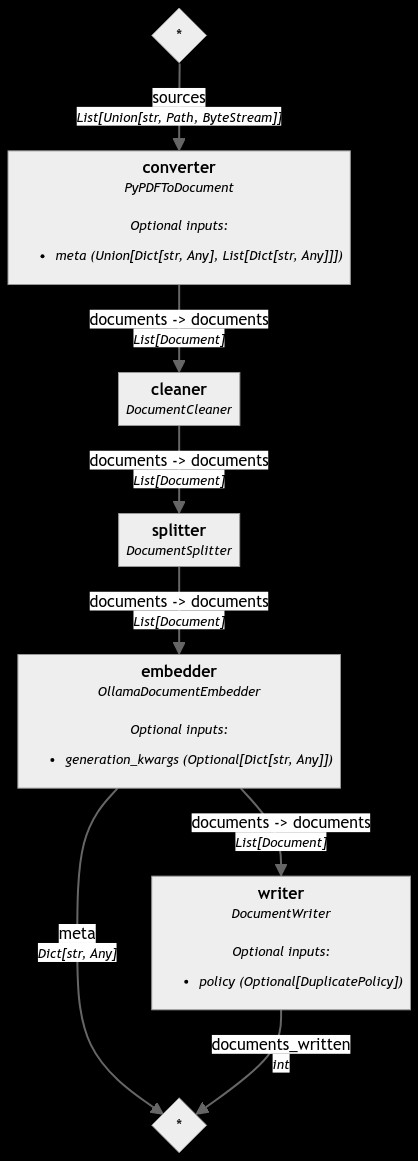

In [9]:
embedding_pipeline.connect("converter", "cleaner")
embedding_pipeline.connect("cleaner", "splitter")
embedding_pipeline.connect("splitter", "embedder")
embedding_pipeline.connect("embedder", "writer")

### Run Embedding Pipeline

In [10]:
embedding_pipeline.run({"converter": {"sources": ["../files/test_pdf_data.pdf"]}})

Calculating embeddings:   0%|          | 0/1 [00:00<?, ?it/s]

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


{'embedder': {'meta': {'model': 'nomic-embed-text'}},
 'writer': {'documents_written': 1}}

## Generator Process 

### Objects for generator process

In [14]:
generator = OllamaGenerator(model="mixtral",
                            url = "http://192.168.178.82:11434/api/generate")
embedding_retriever = PgvectorEmbeddingRetriever(document_store=document_store)
text_embedder = OllamaTextEmbedder( url = "http://192.168.178.82:11434/api/embeddings")
template = """
    Given the following information, answer the question.

    Context: 
    {% for document in documents %}
        {{ document.content }}
    {% endfor %}

    Question: {{ query }}?
    """
prompt_builder = PromptBuilder(template=template)

### Add components to generator pipeline

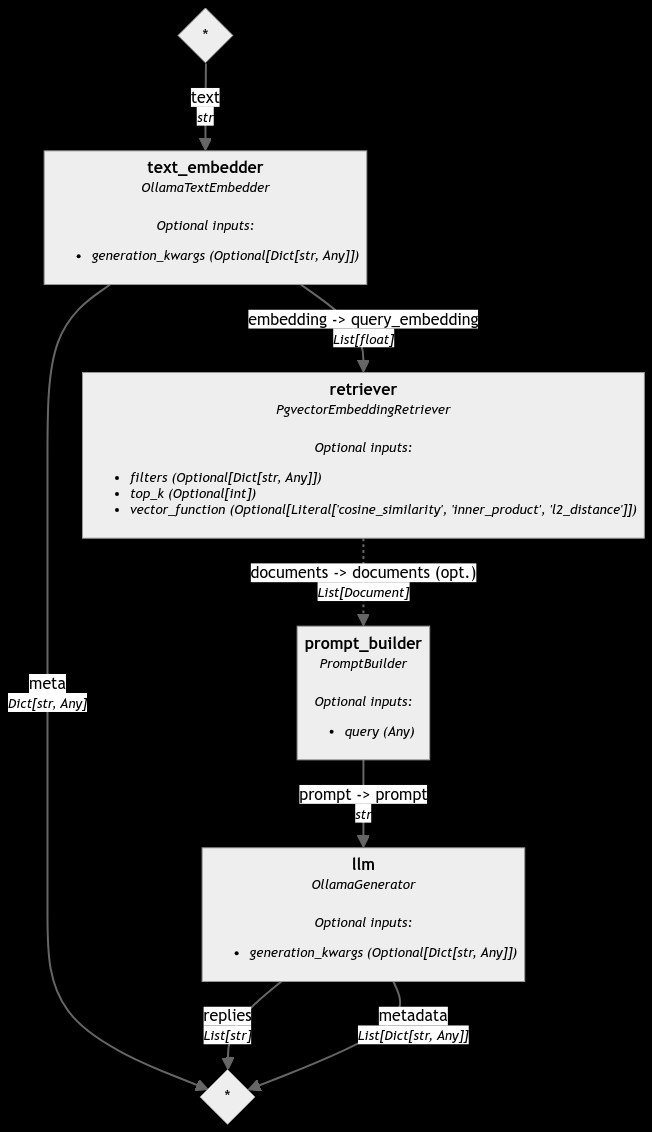

In [15]:
generator_pipeline = Pipeline()
generator_pipeline.add_component("text_embedder", text_embedder)
generator_pipeline.add_component("retriever",  embedding_retriever)
generator_pipeline.add_component("prompt_builder", PromptBuilder(template=template))
generator_pipeline.add_component("llm", generator)
generator_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
generator_pipeline.connect("retriever", "prompt_builder.documents")
generator_pipeline.connect("prompt_builder", "llm")

### Run Generator Pipeline

In [17]:
query="What is the potential of Digital health tools?"
result = generator_pipeline.run({
    "text_embedder":{"text": query},
    "prompt_builder": {
        "query": query
    },
})
print(result)

{'text_embedder': {'meta': {'model': 'nomic-embed-text', 'duration': datetime.timedelta(microseconds=255237)}}, 'llm': {'replies': [' Based on the provided context, digital health tools have the potential to significantly improve the delivery of healthcare services. They can help overcome challenges such as limited adoption due to issues of usability and trust. The text highlights the use of Large Language Models (LLMs) as general-purpose models capable of processing complex information and generating human-like text, offering various applications in healthcare.\n\nHowever, LLMs face challenges when directly applied in clinical settings, such as providing inconsistent or nonsensical answers. To address these issues, the text suggests that LLM-based systems can utilize external tools and provide a novel interface between clinicians and digital technologies, enhancing the utility and practical impact of digital healthcare tools and AI models while addressing current concerns like halluci